# **📦 Bosta Case Study**

**[Please, click on Tableau Dashboard!](https://public.tableau.com/views/BostaCasestudy/Home?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)**

## ✔️**Data Collection**

In [ ]:
# importing necessary packages
!pip install pandasql 
import numpy as np
import pandas as pd
import seaborn as sns
import pandasql as ps
import datetime as dt
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
pd.set_option('max_columns', None)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=25ef9c15a2c9683fd3379ff186f30b59c714840da4c591b756abb8a127a21a2f
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
## importing data tables
merchants_data = pd.read_excel("Data.xlsx", sheet_name="Merchants Data")
signup_table = pd.read_excel("Data.xlsx", sheet_name="Signup Table")
merchants_price_plan = pd.read_excel("Data.xlsx", sheet_name="Merchants Price Plan")
price_plans_details = pd.read_excel("Data.xlsx", sheet_name="Price Plans Details")
transactions_table = pd.read_excel("Data.xlsx", sheet_name="Transactions table")
transactions_table['Date'] = pd.to_datetime(transactions_table['Date'])

## ✔️**Data Cleaning & Manipulation** 

In [ ]:
## joining data into one table for our analysis purpose
query = \
'''
SELECT

-- Retrieving Merchant Data: id, name, signup
  t."Merchant ID",
  m."Name" AS "Merchant Name",  
  s."Signup Date",

-- Retrieving Transaction Data: id, date
  t."Transaction ID",
  t."Date" AS "transaction_date",

-- Retrieving Transaction Type: forward to end user or returning to origin
  t."Transaction Type",
  CASE WHEN t."Transaction Type" = 'FD' THEN 1 ELSE 0 END AS "fd_flag",
  CASE WHEN t."Transaction Type" = 'RTO' THEN 1 ELSE 0 END AS "rto_flag",

-- Retrieving Transaction Delivery Status: delivere or not
  t."Transaction Status",
  CASE WHEN t."Transaction Status" = 'Delivered' THEN 1 ELSE 0 END AS "delivered_flag",
  CASE WHEN t."Transaction Status" <> 'Delivered' THEN 1 ELSE 0 END AS "not_delivered_flag",

-- Retrieving Transaction # of parcels
  t."Number of Parcels",
  CASE WHEN t."Transaction Status" = 'Delivered' THEN t."Number of Parcels" ELSE 0 END AS "delivered_parcels",
  CASE WHEN t."Transaction Status" <> 'Delivered' THEN t."Number of Parcels" ELSE 0 END AS "not_delivered_parcels",

-- Retrieving Parcel/s size
  t."Size",

-- Retrieving shipment amount & payment method  
  t."Shippment Amount",
  CASE WHEN t."Shippment Amount" = 0 THEN 1 ELSE 0 END AS "Credit_order_flag",
  CASE WHEN t."Shippment Amount" <> 0 THEN 1 ELSE 0 END AS "Cash_order_flag",

-- Retrieving Dispatching hub of parcels & Destination city
  t."Dispatching Hub",
  t."Destination City",
  CASE WHEN t."Destination City" = 'Alexandria' THEN 1 ELSE 0 END AS 'dest_alex_flag',
  CASE WHEN t."Destination City" = 'Cairo' THEN 1 ELSE 0 END AS 'dest_cairo_flag',
  CASE WHEN t."Destination City" = 'Tanta' THEN 1 ELSE 0 END AS 'dest_tanta_flag',
  CASE WHEN t."Destination City" = 'Banha' THEN 1 ELSE 0 END AS 'dest_banha_flag',
  CASE WHEN t."Destination City" = 'Mansoura' THEN 1 ELSE 0 END AS 'dest_mansoura_flag',



-- Calculating Revenues Generated
-- Disclaimer: I assumed that the fees are per parcel not the transaction
-- Disclaimer: I assumed that the shippment amounts are collected when the transaction is delivered
-- Disclaimer: I assumed that the total revenues = total revenues of parcels from the merchant + total collected shipment amounts 

  CASE WHEN t."Transaction Type" = 'FD' THEN (ppd."Forward Delivery"*t."Number of Parcels") ELSE 0 END AS "FD_rev",
  CASE WHEN t."Transaction Type" = 'RTO' THEN (ppd."RTO"*t."Number of Parcels") ELSE 0 END AS "RTO_rev",
  CASE WHEN t."Size" = 'Large' THEN (ppd."large"*t."Number of Parcels") ELSE 0 END AS "large_rev",
  CASE WHEN t."Size" = 'Xlarge' THEN (ppd."Xlarge"*t."Number of Parcels") ELSE 0 END AS "Xlarge_rev",
  CASE WHEN t."Destination City" = 'Cairo' THEN (ppd."Cairo"*t."Number of Parcels") ELSE 0 END AS "Cairo_rev",
  CASE WHEN t."Destination City" <> 'Cairo' THEN (ppd."Other Ctities"*t."Number of Parcels") ELSE 0 END AS "Other_Cities_rev",
  CASE WHEN t."Shippment Amount" <> 0 THEN (ppd."Cash Collection"*t."Number of Parcels") ELSE 0 END AS "Cash_Collection_rev",
  CASE WHEN t."Transaction Status" = 'Delivered' THEN t."Shippment Amount" ELSE 0 END AS "Shippment_rev"


-- Joining tables
FROM transactions_table t
JOIN merchants_data m
ON t."Merchant ID" = m."Merchant ID"
JOIN signup_table s
ON m."Merchant ID" = s."Merchant ID"
JOIN merchants_price_plan mpp
ON mpp."Merchant ID" = m."Merchant ID"
JOIN price_plans_details  ppd
ON ppd."Price Plan Name" = mpp."Price Plan"
'''

# storing the data in a pandas dataframe
df = ps.sqldf(query)

In [ ]:
## renaming columns to follow the same naming convention
df.rename( columns= lambda x : x.strip().lower().replace(' ','_'), inplace = True)

In [ ]:
## casting data types
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_id'] = df['transaction_id'].astype('int').astype('str')
df[['delivered_parcels', 'not_delivered_parcels', 'number_of_parcels']] = df[['delivered_parcels', 'not_delivered_parcels', 'number_of_parcels']].astype('int')

## checking dtypes
df.dtypes

merchant_id                      object
merchant_name                    object
signup_date              datetime64[ns]
transaction_id                   object
transaction_date         datetime64[ns]
transaction_type                 object
fd_flag                           int64
rto_flag                          int64
transaction_status               object
delivered_flag                    int64
not_delivered_flag                int64
number_of_parcels                 int64
delivered_parcels                 int64
not_delivered_parcels             int64
size                             object
shippment_amount                float64
credit_order_flag                 int64
cash_order_flag                   int64
dispatching_hub                  object
destination_city                 object
dest_alex_flag                    int64
dest_cairo_flag                   int64
dest_tanta_flag                   int64
dest_banha_flag                   int64
dest_mansoura_flag                int64


In [ ]:
## truncating dates by month & make them user-friendly formatted
df['transaction_month'] = (df['transaction_date'] + pd.offsets.MonthBegin(-1)).apply(lambda x: x.strftime("%b %Y"))
df['signup_month'] = (df['signup_date'] + pd.offsets.MonthBegin(-1)).apply(lambda x: x.strftime("%b %Y"))

In [ ]:
## checking categorical variables consistency and uniqueness
cat_cols = ['size', 'destination_city', 'dispatching_hub']
for col in cat_cols:
  print(f'({col}):\n{df[col].value_counts()}\n-------------------------------\n');

(size):
Normal    3376
Xlarge    1518
Large     1096
Name: size, dtype: int64
-------------------------------

(destination_city):
Alexandria    1852
Cairo         1852
Banha         1367
Mansoura       463
Tanta          456
Name: destination_city, dtype: int64
-------------------------------

(dispatching_hub):
Cairo         3594
Alexandria    1797
Mansoura       599
Name: dispatching_hub, dtype: int64
-------------------------------



In [ ]:
## ckecking numerical variables range validity
df.describe()

,fd_flag,rto_flag,delivered_flag,not_delivered_flag,number_of_parcels,delivered_parcels,not_delivered_parcels,shippment_amount,credit_order_flag,cash_order_flag,dest_alex_flag,dest_cairo_flag,dest_tanta_flag,dest_banha_flag,dest_mansoura_flag,fd_rev,rto_rev,large_rev,xlarge_rev,cairo_rev,other_cities_rev,cash_collection_rev,shippment_rev
count,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.000000,5990.00000,5990.0,5990.000000,5990.000000,5990.000000
mean,0.711018,0.288982,0.813356,0.186644,2.187646,1.776962,0.410684,488.583472,0.104841,0.895159,0.309182,0.309182,0.076127,0.228214,0.077295,72.742905,23.595159,5.251252,12.27379,0.0,13.760434,9.583806,399.847245
std,0.453327,0.453327,0.389658,0.389658,1.860069,1.878867,1.178771,842.501484,0.306375,0.306375,0.462195,0.462195,0.265223,0.419716,0.267082,88.888457,54.163138,15.614249,29.73159,0.0,17.319466,10.853873,785.630554
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,75.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,3.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,150.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.00000,0.0,7.500000,6.000000,100.000000
75%,1.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.000000,300.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,70.000000,30.000000,0.000000,20.00000,0.0,12.500000,12.000000,250.000000
max,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,7.000000,3000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,420.000000,350.000000,105.000000,175.00000,0.0,87.500000,56.000000,3000.000000


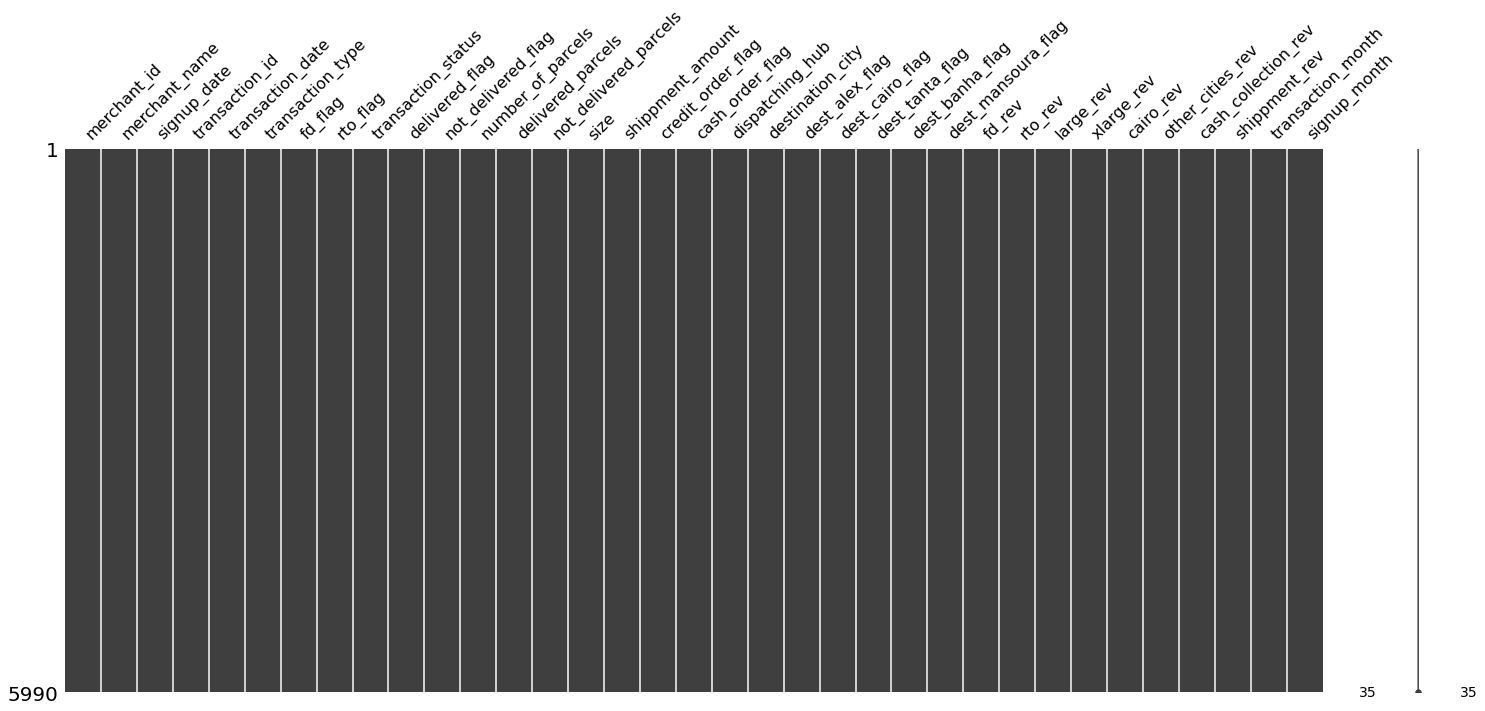

merchant_id              0
merchant_name            0
signup_date              0
transaction_id           0
transaction_date         0
transaction_type         0
fd_flag                  0
rto_flag                 0
transaction_status       0
delivered_flag           0
not_delivered_flag       0
number_of_parcels        0
delivered_parcels        0
not_delivered_parcels    0
size                     0
shippment_amount         0
credit_order_flag        0
cash_order_flag          0
dispatching_hub          0
destination_city         0
dest_alex_flag           0
dest_cairo_flag          0
dest_tanta_flag          0
dest_banha_flag          0
dest_mansoura_flag       0
fd_rev                   0
rto_rev                  0
large_rev                0
xlarge_rev               0
cairo_rev                0
other_cities_rev         0
cash_collection_rev      0
shippment_rev            0
transaction_month        0
signup_month             0
dtype: int64

In [ ]:
## checking for Nulls
msno.matrix(df.sort_values('transaction_id')) # Error at Random || Not
plt.show()
df.isnull().sum()

In [ ]:
## checking for duplicates
df.duplicated(subset='transaction_id', keep=False).value_counts()

False    5990
dtype: int64

In [ ]:
## creating the total revenue column
df['total_rev'] = df['fd_rev'] + df['rto_rev'] + df['large_rev'] + df['xlarge_rev'] + df['cairo_rev'] + df['other_cities_rev'] + df['cash_collection_rev'] + df['shippment_rev']

In [ ]:
## getting 1st order date / merchant
query1 = \
'''
SELECT
  merchant_id,
  MIN(transaction_date) AS '1st_order_date'
FROM df
GROUP BY merchant_id
'''
first_orders_dates = ps.sqldf(query1)

In [ ]:
## appending 1st order date to merchants
query2 = \
'''
SELECT
  df.*,
  fod."1st_order_date"
FROM df 
JOIN first_orders_dates fod
ON df."merchant_id" = fod."merchant_id"
'''
df = ps.sqldf(query2)
df['1st_order_date'] = pd.to_datetime(df['1st_order_date'])
df['1st_order_month'] = (df['1st_order_date'] + pd.offsets.MonthBegin(-1)).apply(lambda x: x.strftime("%b %Y"))
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [ ]:
## inspecting the data
display(df.sample(3))
display(df.columns)

,merchant_id,merchant_name,signup_date,transaction_id,transaction_date,transaction_type,fd_flag,rto_flag,transaction_status,delivered_flag,not_delivered_flag,number_of_parcels,delivered_parcels,not_delivered_parcels,size,shippment_amount,credit_order_flag,cash_order_flag,dispatching_hub,destination_city,dest_alex_flag,dest_cairo_flag,dest_tanta_flag,dest_banha_flag,dest_mansoura_flag,fd_rev,rto_rev,large_rev,xlarge_rev,cairo_rev,other_cities_rev,cash_collection_rev,shippment_rev,transaction_month,signup_month,total_rev,1st_order_date,1st_order_month
5307,68a4e330-b69a-496c-b8e0-e9b1aed8103a,Rupert Blair,2022-12-22,5308,2023-01-06,FD,1,0,Delivered,1,0,1,1,0,Normal,300.0,0,1,Alexandria,Banha,0,0,0,1,0,40.0,0.0,0.0,0.0,0.0,7.5,3.0,300.0,Jan 2023,Dec 2022,350.5,2022-12-29,Dec 2022
1651,2a04eed1-ee50-4234-8550-b38ce55c0ba3,Büşra Koyun,2020-07-06,1652,2020-07-06,FD,1,0,Delivered,1,0,1,1,0,Normal,200.0,0,1,Cairo,Alexandria,1,0,0,0,0,45.0,0.0,0.0,0.0,0.0,7.5,4.0,200.0,Jul 2020,Jul 2020,256.5,2020-07-06,Jul 2020
1507,1458d6bd-5251-48c7-8e41-18f438d4d0cc,Augusto Parente,2020-05-19,1508,2020-05-31,RTO,0,1,Delivered,1,0,1,1,0,Xlarge,500.0,0,1,Alexandria,Cairo,0,1,0,0,0,0.0,30.0,0.0,20.0,0.0,0.0,3.0,500.0,May 2020,May 2020,553.0,2020-05-26,May 2020


Index(['merchant_id', 'merchant_name', 'signup_date', 'transaction_id',
       'transaction_date', 'transaction_type', 'fd_flag', 'rto_flag',
       'transaction_status', 'delivered_flag', 'not_delivered_flag',
       'number_of_parcels', 'delivered_parcels', 'not_delivered_parcels',
       'size', 'shippment_amount', 'credit_order_flag', 'cash_order_flag',
       'dispatching_hub', 'destination_city', 'dest_alex_flag',
       'dest_cairo_flag', 'dest_tanta_flag', 'dest_banha_flag',
       'dest_mansoura_flag', 'fd_rev', 'rto_rev', 'large_rev', 'xlarge_rev',
       'cairo_rev', 'other_cities_rev', 'cash_collection_rev', 'shippment_rev',
       'transaction_month', 'signup_month', 'total_rev', '1st_order_date',
       '1st_order_month'],
      dtype='object')

In [ ]:
## exporting the data
df.to_csv('00. clean-analysis-data.csv', index=False)

## ✔️**Q1: KPIs**

> **Business Overall visibility**

In [ ]:
################################################
# Claculating Business Overall Visibility KPIs #
################################################
query_bov = \
'''
SELECT
  transaction_month AS "Month",
  SUM(total_rev) AS "Total Rev",
  SUM(large_rev + 'xlarge_rev') AS "Total Large and XLarge Rev",
  SUM(cash_collection_rev) AS "Total Cash Collection Rev",
  SUM(other_cities_rev) AS "Total Outside Cairo Rev",
  SUM(delivered_parcels) AS "# Delivered Parcels",
  SUM(shippment_rev) AS "Total Collected Cash",
  SUM(cash_order_flag) AS "# Cash Orders",
  SUM(credit_order_flag) AS "# Credit Orders"
FROM df
GROUP BY transaction_month
ORDER BY transaction_date ASC
'''
bov = ps.sqldf(query_bov)

> **Merchants Base Metrics**

In [ ]:
####################################
# monthly active and new merchants #
####################################
query_act_new = \
'''
SELECT
  transaction_month AS "Month",
  COUNT(DISTINCT merchant_id) AS "# active merchants",
  COUNT(DISTINCT(CASE WHEN "1st_order_month" = "transaction_month"  THEN  merchant_id END)) AS "# new merchants"
FROM df
GROUP BY transaction_month
ORDER BY transaction_date ASC
'''
active_new = ps.sqldf(query_act_new)


####################################################################################
# monthly retained merchants (Merchants that are retained from the previous month) #
####################################################################################
df['transaction_month_date'] = pd.to_datetime(df['transaction_month'])
query_ret = \
'''
WITH user_activity as ( SELECT DISTINCT
                                 transaction_month_date AS "Month",
                                 merchant_id
                           FROM df
                           ORDER BY transaction_month_date ASC)

SELECT
  DATE(previous.Month) AS "Month",
  COUNT(DISTINCT current.merchant_id) AS "# retained merchants"

FROM user_activity AS previous
LEFT JOIN user_activity AS current
  ON previous.merchant_id = current.merchant_id
AND
  DATE(previous.Month) = DATE(current.Month, '1 month')
GROUP BY DATE(previous.Month)
ORDER by DATE(previous.Month)
'''
retained = ps.sqldf(query_ret)
retained['Month'] = pd.to_datetime(retained['Month']).apply(lambda x: x.strftime("%b %Y"))


###################
# monthly signups #
###################
query_signs = \
'''
SELECT
  signup_month AS "Month",
  COUNT(DISTINCT merchant_id) AS "# sign-ups"
FROM df
GROUP BY signup_month
ORDER BY signup_date ASC
'''
sign_ups = ps.sqldf(query_signs)


########################
# joining all together #
########################
query_mbm = \
'''
SELECT
    an."Month",
    an."# active merchants",
    an."# new merchants",
    r."# retained merchants",
    COALESCE(s."# sign-ups", 0) AS "# sign-ups"
FROM active_new an
JOIN retained r
ON an.Month = r.Month
LEFT JOIN sign_ups s
ON r.Month = s.Month
'''
mbm = ps.sqldf(query_mbm)



#################################################################################################################
# monthly reactivated merchants (Merchants that were not active last month, however they are not new merchants) #
#################################################################################################################
mbm['# reactivated merchants'] = mbm['# active merchants'] - mbm['# new merchants'] - mbm['# retained merchants']
mbm = mbm[['Month', '# sign-ups', '# active merchants', '# new merchants', '# retained merchants', '# reactivated merchants']]

> **Operations Metrics**

In [ ]:
##################################
# Claculating Operations Metrics #
##################################
query_opm = \
'''
SELECT
  transaction_month AS "Month",
  ROUND(COALESCE(AVG(delivered_flag), 0), 2) AS "Delivery success Rate",
  ROUND(COALESCE(AVG(CASE WHEN fd_flag = 1 THEN delivered_flag END), 0), 2) AS "FD Delivery success Rate",
  ROUND(COALESCE(AVG(CASE WHEN fd_flag = 0 THEN delivered_flag END), 0), 2) AS "RTO Delivery success Rate"
FROM df
GROUP BY transaction_month
ORDER BY transaction_date ASC
'''
opm = ps.sqldf(query_opm)

> **Full-view**

In [ ]:
#############################
# Getting Full View of KPIs #
#############################
kpis = bov.merge(mbm, how='inner', on='Month').merge(opm, how='inner', on='Month')
kpis.to_csv('01. KPIs.csv', index=False)
kpis.head(10)

,Month,Total Rev,Total Large and XLarge Rev,Total Cash Collection Rev,Total Outside Cairo Rev,# Delivered Parcels,Total Collected Cash,# Cash Orders,# Credit Orders,# sign-ups,# active merchants,# new merchants,# retained merchants,# reactivated merchants,Delivery success Rate,FD Delivery success Rate,RTO Delivery success Rate
0,Apr 2019,1314.0,0.0,34.0,45.0,6,945.0,5,0,10,5,5,0,0,1.00,1.00,0.00
1,May 2019,31454.5,245.0,512.0,817.5,107,23650.0,50,4,15,20,16,4,0,0.96,0.96,0.00
2,Jun 2019,54092.5,450.0,820.0,1142.5,163,42695.0,69,4,18,27,17,10,0,0.92,0.92,0.00
3,Jul 2019,65279.5,715.0,907.0,1332.5,239,49935.0,115,11,14,32,13,19,0,0.91,0.91,0.00
4,Aug 2019,70557.5,790.0,1180.0,1777.5,245,52305.0,118,15,16,43,20,22,1,0.81,0.82,0.00
5,Sep 2019,72408.5,680.0,1311.0,1967.5,261,51510.0,142,17,20,46,22,23,1,0.76,0.77,0.33
6,Oct 2019,80222.5,820.0,1340.0,1857.5,240,60240.0,124,12,21,45,19,24,2,0.84,0.86,0.64
7,Nov 2019,59522.0,770.0,937.0,1325.0,179,44365.0,97,11,9,35,10,24,1,0.73,0.74,0.67
8,Dec 2019,63995.5,285.0,1323.0,1712.5,235,46475.0,110,11,14,38,12,24,2,0.89,0.89,0.91
9,Jan 2020,80710.0,660.0,1270.0,1960.0,224,62025.0,125,14,16,44,14,26,4,0.80,0.80,0.75


## ✔️**Q2: Cohort Analysis**

In [ ]:
##################################
# preparing cohort analysis data #
##################################
def get_month(x): return dt.datetime(x.year, x.month, 1) 
df['TransactionMonth'] = df['transaction_date'].apply(get_month) 
grouping = df.groupby('merchant_id')['TransactionMonth']
df['CohortMonth'] = grouping.transform('min')
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
transcation_year, transaction_month, _ = get_date_int(df, 'TransactionMonth')
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')
years_diff = transcation_year - cohort_year
months_diff = transaction_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff  + 1 

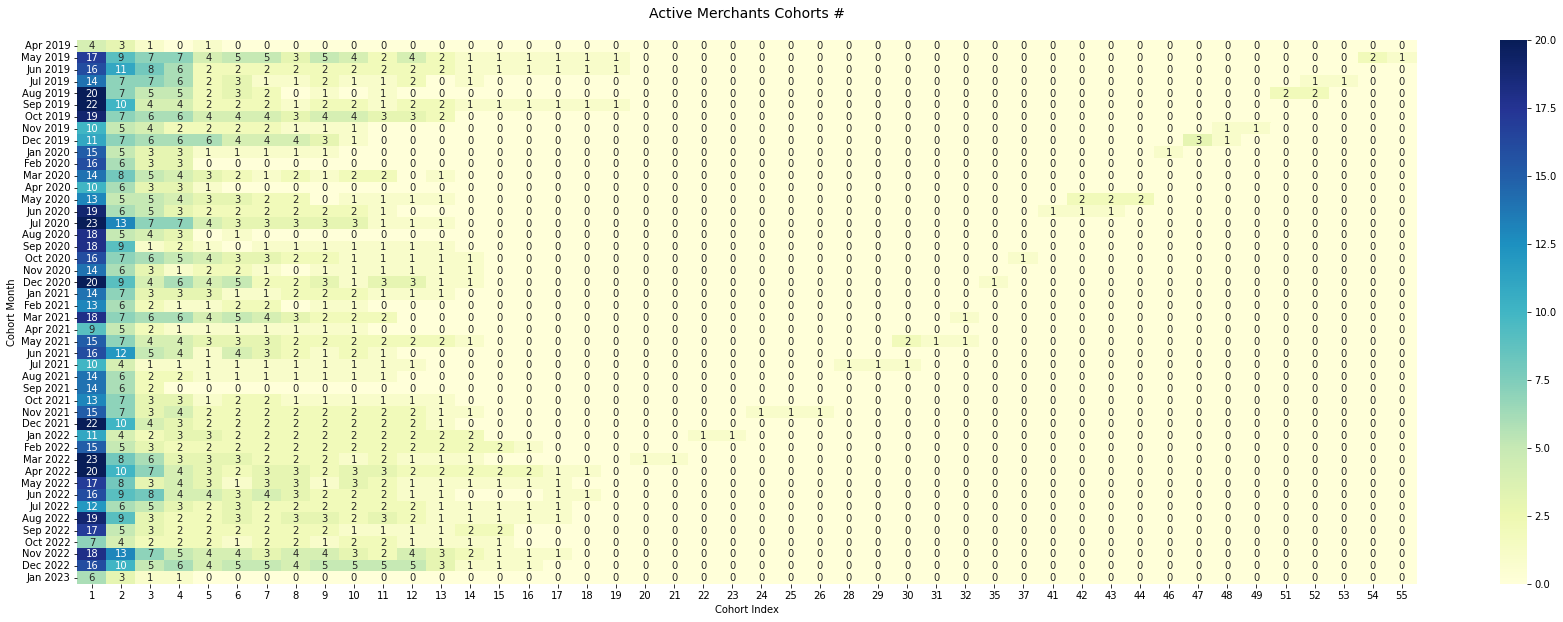

In [ ]:
############################
# Active Merchants Cohorts #
############################
active_user_cohorts = pd.pivot_table(data=df,
                                     index='CohortMonth',
                                     columns ='CohortIndex',
                                     values = 'merchant_id',
                                     aggfunc = pd.Series.nunique,
                                     fill_value=0)
active_user_cohorts.index = active_user_cohorts.index.strftime("%b %Y")
plt.figure(figsize=(30, 10))
plt.title('Active Merchants Cohorts #\n', fontsize = 14)
sns.heatmap(active_user_cohorts, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

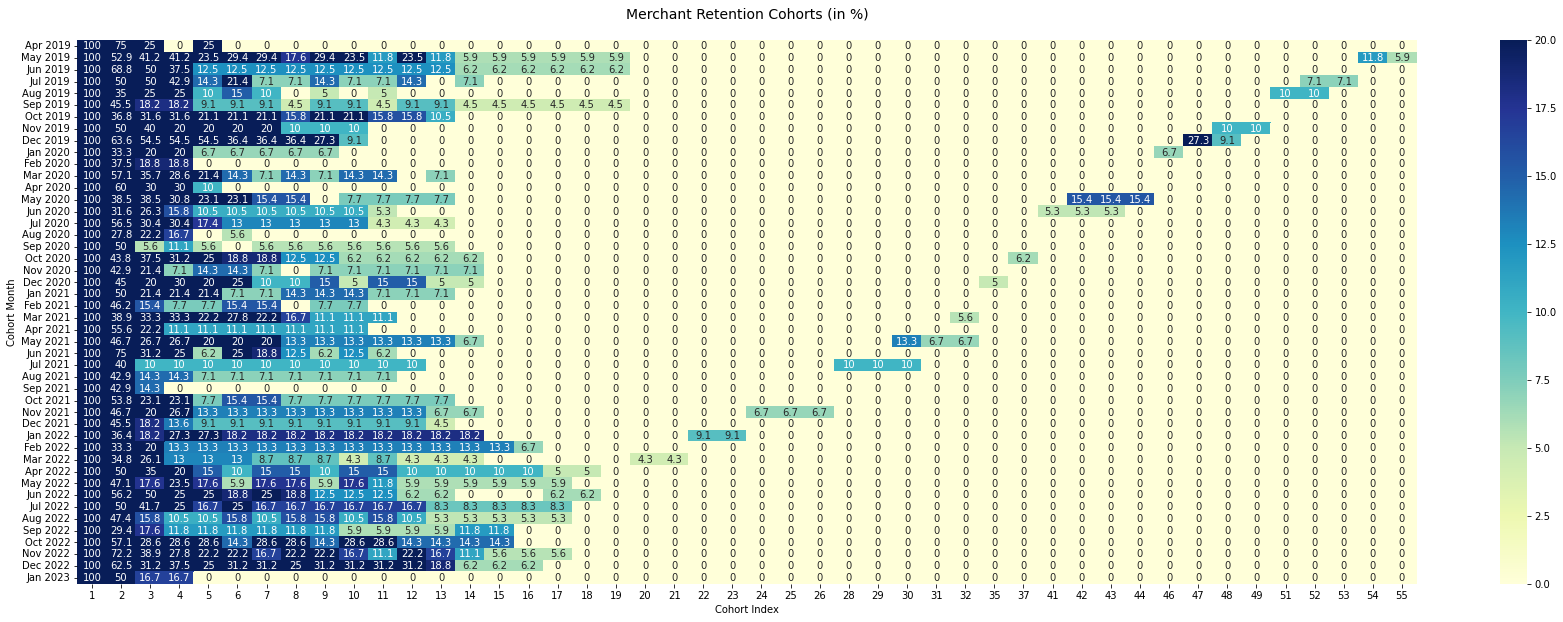

In [ ]:
#####################
# Retention Cohorts #
#####################
cohort_sizes = active_user_cohorts.iloc[:,0]
retention_cohorts = active_user_cohorts.divide(cohort_sizes, axis=0).round(3)*100
plt.figure(figsize=(30, 10))
plt.title('Merchant Retention Cohorts (in %)\n', fontsize = 14)
sns.heatmap(retention_cohorts, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

In [ ]:
######################
# Exporting the data #
######################
active_user_cohorts.stack().to_csv('02.1 Active Merchants Cohorts.csv')
retention_cohorts.stack().to_csv('02.2 Retained Merchants Cohorts.csv')

## ✔️**Q3: Hubs' Performance**

In [ ]:
####################################
# Claculating Hub Performance KPIs #
####################################

query_hub_performance= \
'''
SELECT
  transaction_month AS "Month",
  dispatching_hub AS "Hub",
  COUNT(transaction_id) AS "# of Dispatched Orders",
  SUM(fd_flag) AS "# FD Orders",
  SUM(rto_flag) AS "# RTO Orders",
  ROUND(COALESCE(AVG(delivered_flag), 0), 2) AS "Delivery success Rate %",
  ROUND(COALESCE(AVG(CASE WHEN fd_flag = 1 THEN delivered_flag END), 0), 2) AS "FD Delivery success Rate %",
  ROUND(COALESCE(AVG(CASE WHEN fd_flag = 0 THEN delivered_flag END), 0), 2) AS "RTO Delivery success Rate %",
  SUM(total_rev) AS "Total Rev",
  SUM(dest_cairo_flag) AS "# Cairo Orders",
  SUM(dest_alex_flag) AS "# Alex Orders", 
  SUM(dest_tanta_flag) AS "# Tanta Orders",
  SUM(dest_banha_flag) AS "# Banha Orders",
  SUM(dest_mansoura_flag) AS "# Mansoura Orders" 
FROM df
GROUP BY transaction_month, dispatching_hub
ORDER BY transaction_date ASC
'''
hper = ps.sqldf(query_hub_performance)
hper.to_csv('03. Hubs Performance.csv')
hper.head(10)

,Month,Hub,# of Dispatched Orders,# FD Orders,# RTO Orders,Delivery success Rate %,FD Delivery success Rate %,RTO Delivery success Rate %,Total Rev,# Cairo Orders,# Alex Orders,# Tanta Orders,# Banha Orders,# Mansoura Orders
0,Apr 2019,Cairo,5,5,0,1.00,1.00,0.0,1314.0,1,3,1,0,0
1,May 2019,Mansoura,5,5,0,1.00,1.00,0.0,4726.5,2,2,0,1,0
2,May 2019,Cairo,31,31,0,0.94,0.94,0.0,20060.5,9,8,1,12,1
3,May 2019,Alexandria,18,18,0,1.00,1.00,0.0,6667.5,5,5,3,2,3
4,Jun 2019,Alexandria,21,21,0,0.95,0.95,0.0,12143.5,10,8,1,2,0
5,Jun 2019,Mansoura,8,8,0,0.88,0.88,0.0,6868.5,4,1,0,2,1
6,Jun 2019,Cairo,44,44,0,0.91,0.91,0.0,35080.5,9,14,6,10,5
7,Jul 2019,Mansoura,12,12,0,0.92,0.92,0.0,5848.0,7,2,1,2,0
8,Jul 2019,Cairo,76,76,0,0.89,0.89,0.0,46586.0,29,18,7,16,6
9,Jul 2019,Alexandria,38,38,0,0.95,0.95,0.0,12845.5,11,10,1,15,1


## ✔️**Q4: Merchants' Segmentation**


In [ ]:
##########################################
# Retrieving Merchants Segmentation Data #
##########################################

query_seg = \
'''

-- Disclaimer: volume will be (# of orders) & (# of parcels) 
-- Disclaimer: Collected cash is considered as the shipment fees of the delivered orders 

SELECT
  merchant_id,
  merchant_name,
  COUNT(transaction_id) AS "#_of_orders",
  SUM(number_of_parcels) AS "#_of_parcels",
  SUM(shippment_rev) AS "total_collected_cash",
  ROUND(COALESCE(AVG(delivered_flag), 0), 2) AS "delivery_success_rate"
FROM df
GROUP BY merchant_id, merchant_name
ORDER BY merchant_name ASC
'''
segmentation_data = ps.sqldf(query_seg)
segmentation_data.head(3)

,merchant_id,merchant_name,#_of_orders,#_of_parcels,total_collected_cash,delivery_success_rate
0,5591a312-6cc5-4b10-bf00-e5b6e3c0ed7a,Aaron Giles,46,106,20440.0,1.0
1,4b0ed9fb-8635-4efb-bbe9-b70807501a2d,Abdullah bin Kassim,5,18,145.0,0.4
2,7fa727c2-7161-4212-b20f-f1b5e079a544,Achille Serafini,2,5,75.0,1.0


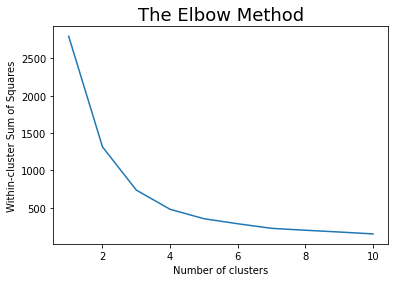

In [ ]:
##############################################################################
### Statistical Segmentation (i.e Not Rule-Based Managerial Segmentation) ###
##############################################################################

## Selecting Features
x = segmentation_data[['merchant_id', 'merchant_name', '#_of_orders', '#_of_parcels', 'total_collected_cash', 'delivery_success_rate']]
x.set_index(['merchant_id', 'merchant_name'], inplace = True)

## Scaling Features
x_scaled = StandardScaler().fit(x).transform(x)

## Finding the Best K
wcss=[]
for k in range(1,11):
    kmeans = KMeans(k, init='k-means++', random_state=96)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
number_clusters = range(1,11)
sns.lineplot(x=number_clusters, y=wcss);
plt.title('The Elbow Method', fontsize= 18);
plt.xlabel('Number of clusters');
plt.ylabel('Within-cluster Sum of Squares');
plt.show()

In [ ]:
#################################################
# Building a model with the best # of clusters ##
#################################################

## Modeling
kmeans = KMeans(3, init='k-means++', random_state=96)
kmeans.fit(x_scaled)

## Assigning clusters to merchants data
x['Cluster'] = kmeans.labels_+1
x.to_csv('04.1 Clustered Merchants.csv')

In [ ]:
##############################################
## Profiling Merchants Based on the Results ##
##############################################

merchants_prrofiles = x.groupby(['Cluster']).agg({'#_of_orders': 'mean',
                                                  '#_of_parcels': 'mean',
                                                  'total_collected_cash': 'mean',
                                                  'delivery_success_rate': ['mean', 'count']}).round(2)
merchants_prrofiles = pd.DataFrame(merchants_prrofiles)
merchants_prrofiles['%'] = (round(merchants_prrofiles['delivery_success_rate']['count'] / merchants_prrofiles['delivery_success_rate']['count'].sum(), 2) * 100).astype('int').astype('str') + '%'



merchants_prrofiles['Description'] = ['frequent, high volume, high cash collector, good delivery rate',
                                      'low frequency, low volume, low cash collector, excellenct delivery rate',
                                      'low frequency, low volume, low cash collector, bad delivery rate'] 
merchants_prrofiles = merchants_prrofiles[['Description', '#_of_orders', '#_of_parcels', 'total_collected_cash', 'delivery_success_rate', '%']]
merchants_prrofiles.to_csv('04.2 Merchants Profiles.csv')
merchants_prrofiles

Description #_of_orders  \
                                                                  mean   
Cluster                                                                  
1        frequent, high volume, high cash collector, go...       34.29   
2        low frequency, low volume, low cash collector,...        4.00   
3        low frequency, low volume, low cash collector,...        6.66   

        #_of_parcels total_collected_cash delivery_success_rate          %  
                mean                 mean                  mean count       
Cluster                                                                     
1              75.18             14606.67                  0.86    90  13%  
2               8.64              1912.90                  1.00   433  62%  
3              14.76              1432.95                  0.47   176  25%

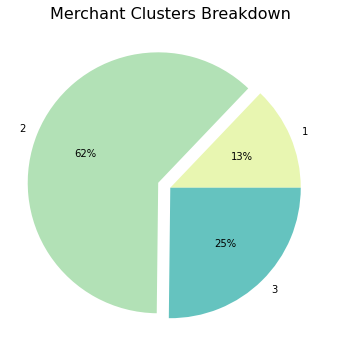

In [ ]:
###################################
# Visualizing Clusters Breakdown ##
###################################

data = merchants_prrofiles['delivery_success_rate']['count']
keys = merchants_prrofiles.index
explode = [0, 0.1, 0]
palette_color = sns.color_palette("YlGnBu")
plt.figure(figsize=(10, 6))
plt.title('Merchant Clusters Breakdown', fontsize=16);
plt.pie(data, labels=keys, colors=palette_color, explode=explode, autopct='%.0f%%')
plt.savefig('04.3 Merchant Clusters Breakdown.png')
plt.show()

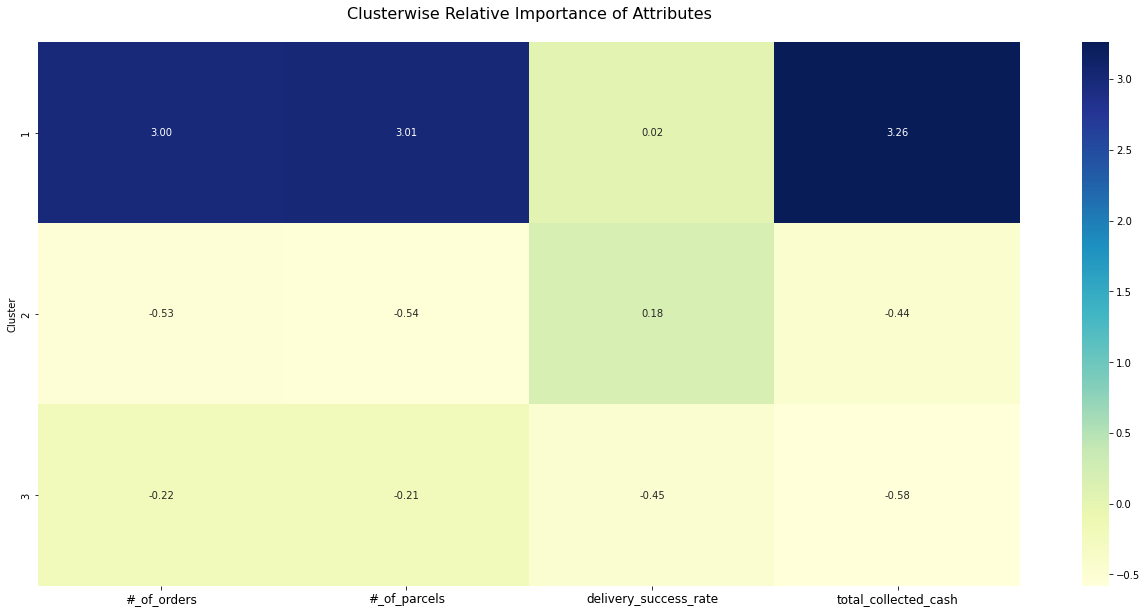

In [ ]:
###############################################
# Visualizing Attributes Relative Importance ##
###############################################

## Relative Importance Heatmap
cluster_avg = x.groupby(['Cluster']).mean()
population_avg = x.mean()
relative_importance = (cluster_avg / population_avg - 1).round(2)
relative_importance.drop( 'Cluster', axis=1, inplace= True )
plt.figure(figsize=(22, 10));
plt.title('Clusterwise Relative Importance of Attributes\n', fontsize=16);
plt.xticks(fontsize=12);
sns.heatmap(data=relative_importance, annot=True, fmt='.2f', cmap='YlGnBu');
plt.savefig('04.4 Clusterwise Relative Importance of Attributes.png')
plt.show()

> Based on the previous insights, we can better know our merchants behaviors and groups. So, we can target them effectively yet efficienty by customized services for better business performance.

> Also, we can apply **RFM-based** segmentation for more insights (e.g. recency & tenure.)